# Milestone Project 2: SkimLit

The purpose of this notebook is to build an NLP model to make reading medical abstrats easier.


  The paper we're replicating ( the source of the dataset tha we'll be using ) is availabel here: https://arxiv.org/abs/1710.06071

  And reading through the paper above,
  we see that the model architecture that they use to achieve their best results is avaliable here: https://arxiv.org/abs/1612.05251

**Resource** If you want to find the ground truth for this notebook (with losts a diagram lots of diagrams and text annotations) see the GitHub:

https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb



## Confirm acces to a GPU

In [23]:
!nvidia-smi

Thu May 20 19:27:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    30W /  70W |    222MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get data

Since we'll be replicating the paper above(PubMed 200k RCT), let's  download the

dataset they used.


We can do so from the authors GitHub:  https://github.com/Franck-Dernoncourt/pubmed-rct


In [24]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [25]:
# Check what files are in the PubMed_20k dataset

!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/
!ls pubmed-rct/PubMed_20k_RCT/
# dev es validation set

dev.txt  test.txt  train.txt
dev.txt  test.txt  train.txt


In [26]:
# Start our experiments using the 20k dataset with numbers replaced by "@" sign
data_dir ="/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"




In [27]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]

filenames



['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess data

Now we'got some text data, it's time to become one with it.

And one of the best ways to become one with the data is to...

> Visualize, visualize, visualize

So with that in mind, let's write a function to read in all of the lines of the lines of a target text file


In [28]:
# Create function to read the lines of a document

def get_lines(filename):
  """
  
  Reads filename(a text filename) and return the lines of text as a list.


  Args:
    filename: a string containing the target filepath.

  returns:

  A list of strings with one string per line from the target filename.



  
  
  """

  with open(filename, "r") as f:

    return f.readlines()

In [29]:
# Let's read in the training lines

train_lines = get_lines(data_dir + "train.txt") # read the lines with the training file

train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [30]:
len(train_lines)

210040

Let's think about how we want our data to look...


How  I think our data would be best represented

```
[{'line_number':0,
  'target': 'BACKGROUND',
  'text': 'Emotional eating is associeated with overeating and the development of obesity. \n',
  'total lines':11},
  ....]


```

es decir deberia retornarme una lista de 11 diccionarios


Let's write a function wich turns each of our datasets into the above format so we can continue to prepare our 
data for modeling.




In [31]:
# tener en cuenta como comienza cada sentencia, como esta separada y como termina

def preprocess_text_with_line_numbers(filename):

  """
  Returns a list of dictionaries of abstrac line data.


  Takes in filename, reads it contents and sorts through each line,

extracting thing like the target label, the text of the sentence, how many sentences are
in the current abstract and what sentence number the target line is

  
  
  """
  input_lines = get_lines(filename)# get all lines from filename

  abstract_lines = "" # Create an empty abstract(string)
  # esta variabla almacenara todas las lineas para un abstract
  abstract_samples = [] # Create an empty list of abstracts


    # """ Con el codigo de abajo agrupamos el texto en distintos abstract"""
  # Loop through each line in the target file
  for line in input_lines:

    # startwith me retorna una valor booleano
    if line.startswith("###"): # check to see if the line is an ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line
    
    elif line.isspace(): # check to see if line is  a new line o salto de linea
      
      # separamos lo que contiene toda las lineas, en varias lineas
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # """  Para cada abstract  hacemos lo siguiente"""
      
      # Iterate through each line in a single abstract and count them at the same time
      # line = sentence
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line

        # separamos con "\t""
        target_text_split = abstract_line.split("\t") # split target label from text

        #append

        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and low it

        line_data["line_number"] = abstract_line_number# what number line does the line appear in the abstract?

        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract?(start from 0)

        abstract_samples.append(line_data) # add line data to abstract sample list
      
    else: # if the above condiction aren't fulfilled, the line contains a labelled sentence

        # si no se cumple lo arriba estamos entre el inicio y el final, oseamos estamos en el mismo abstract
        # relleno mi contenedor de lineas
        abstract_lines += line

  return abstract_samples


In [32]:

# Get data from file and preprocess it

%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")

val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation dataset

test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")



CPU times: user 451 ms, sys: 85 ms, total: 536 ms
Wall time: 540 ms


In [33]:
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [34]:
# Check the first abstract of our training data

train_samples[:10]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

Now that our datta is the format of a list of dictionaries, how about we turn it into DataFrame to further visualize it?



In [35]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)

test_df = pd.DataFrame(test_samples)

train_df.head()


,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [36]:
# Distribution of labels  in training data

#train_df.target.value_counts()

train_df["target"].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

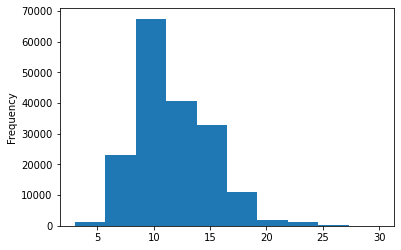

In [37]:
# Let's check the length of different lines

train_df.total_lines.plot.hist();

### Get list of sentences

In [38]:
# Convert abstract text lines into list

train_sentences = train_df["text"].tolist()

val_sentences = val_df["text"].tolist()

test_sentences = test_df["text"].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)



(180040, 30212, 30135)

In [39]:
# View the 10 lines of the training sentences

train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric label)



In [40]:
# One hot encode labels


from  sklearn.preprocessing import OneHotEncoder


one_hot_encoder = OneHotEncoder(sparse=True) # we want non-sparse matrix


train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))

# Check what one hot encoded labels look like
train_labels_one_hot


<180040x5 sparse matrix of type '<class 'numpy.float64'>'
	with 180040 stored elements in Compressed Sparse Row format>

In [41]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

# como tensorflow es incompatible con sparse matrix debemos asegurarnos de poner a falso el one_hot encoder

ValueError: ignored

In [42]:
# One hot encode labels


from  sklearn.preprocessing import OneHotEncoder


one_hot_encoder = OneHotEncoder(sparse=False) # we want non-sparse matrix


train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))

# como ya heamos adecuado el  one hot encoder, ya no necesitamos hacer otro fit para el conjjunto de test(porque tiene las mismas propiedas)
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))
# Check what one hot encoded labels look like


train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [43]:
# Extract labels ( "target" columns ) and encode them into integers
# no necesita el reshape(-1, 1)

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_labels_encoded  = label_encoder.fit_transform(train_df["target"].to_numpy())

val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())

test_label_encoded = label_encoder.transform(test_df["target"].to_numpy())


# check what training labels look like

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [44]:
# Get class names and number of classes from LabelEncoder instance ( reverse enginering)

num_classes = len(label_encoder.classes_)

class_names = label_encoder.classes_

num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments....

As usual, we're going to be trying out a bunch of different models and seeing which one works best.

And as always, we're going to start with a baseline (TF-IDF Multinomial Naive Bayes Classifier)




## Model 0: Getting a a baseline

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB

from sklearn.pipeline import Pipeline




# Create a pipeline
# le pasamos una lista de tuplas
model_0 = Pipeline([
                    
                    ("tf-idf", TfidfVectorizer()),
                    ("clf", MultinomialNB())

])

# Fit the pipeline to the training data

model_0.fit(X=train_sentences,
            y=train_labels_encoded)



Pipeline(memory=None,
         steps=[('tf-idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [46]:
# Evaluate baseline model on validation dataset
#score = evaluate in keras
model_0.score(X=val_sentences,
                 y=val_labels_encoded)

0.7218323844829869

In [47]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)

baseline_preds


array([4, 1, 3, ..., 4, 4, 1])

In [48]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

### Download helper function script

In the previous module, we wrote a function to compare predictions across different metrics ( accuracy, precision_recall and f1)
and rather than rewriting it here, let's download it from our helper function script
https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


In [49]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-05-20 19:27:55--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-05-20 19:27:55 (95.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [50]:
from helper_functions import calculate_results

In [51]:
#Calculate baseline results

baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

In [52]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Preparing our data (the text) for deep sequence models

Before we start building deeper models, we've got to create a vectorization and embedding layers.

In [53]:
import numpy as np
import tensorflow as tf


from tensorflow.keras import layers



In [54]:
train_sentences[1]

'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .'

In [55]:
train_sentences[1].split()

['a',
 'total',
 'of',
 '@',
 'patients',
 'with',
 'primary',
 'knee',
 'oa',
 'were',
 'randomized',
 '@:@',
 ';',
 '@',
 'received',
 '@',
 'mg/day',
 'of',
 'prednisolone',
 'and',
 '@',
 'received',
 'placebo',
 'for',
 '@',
 'weeks',
 '.']

In [56]:
# How long is each sentence on average?


# lista que contiene la longitud de cada sentencia 
sent_len = [len(sentence.split()) for sentence in train_sentences]

avg_sent_len = np.mean(sent_len)

avg_sent_len

# cada sentencia dentro de nuestros batches deben tener la misma forma  por eso buscamos un pormedio

26.338269273494777

In [57]:
# What's the distribution look like ?

import matplotlib.pyplot as plt

plt.hist(sent_lens, bins=20);


NameError: ignored

In [58]:
# How long of a sentence lenght covers 95% of examples?
# necesitamos una longitud que cubra la mayor parte de los datos, lo datos por encima se truncan y los por debajo se "pad/rellenan"


# donde se ubica el 95 porciento de los datos
output_seq_len = int(np.percentile(sent_len, 95))

output_seq_len



55

In [59]:
# Maximum  sequence length in the training set

max(sent_lens)

NameError: ignored

### Create text vectorizer layer

We want to make a layer which maps our texts from words to numbers(integer).





In [60]:
# How many words are in our vocab? ( taken from table 2 in : https//arxiv.org/pdf/1710.06071.pdf)

max_tokens = 68000


In [61]:
# Create text vectorizer

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=output_seq_len)# desired output length of vectorizerd sequence

In [62]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)


In [63]:
# Test out text  vectorizer on random sentences

import random

target_sentence = random.choice(train_sentences)

print(f"Text:\n{target_sentence}")

print(f"\nLength of text:{len(target_sentence.split())}")

print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

# los "0" vienden del padding 
# las palabras mas comunes tienen el numero menor en este caso

Text:
acceptance : examinees preferred the etdrs test ( p < @ ) , the examiner on average had no preference .

Length of text:21

Vectorized text: [[ 2245 23185  1955     2  8089   128    14     2  8087    18   405    55
     33  1845     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [64]:
# How many words in our training vocabulary

# rct es el data set que estamos usando
rct_20k_text_vocab = text_vectorizer.get_vocabulary()


print(f"Number of words in vocab:{len(rct_20k_text_vocab)}")

print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")

print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab:64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [65]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': True,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True}

### Create custom text embedding



In [66]:
# Create token embedding layer

token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), #length of vocabulary
                              output_dim=128, # Nore: different embedding sizes result in drastically different numbers of parameters to train)
                              # para que trabaje mejor con 0
                              mask_zero=True, # use masking to handle variable sequence lengths(save space)
                              name="token_embedding")


In [67]:
# Show example embedding

print(f"Sentence before vectorization:\n {target_sentence}")

vectorized_sentence = text_vectorizer([target_sentence])

print(f"Sentences after vectorization (before embdding): \n {vectorized_sentence}")

embedded_sentence = token_embed(vectorized_sentence)

print(f"Sentences after embedding:\n {embedded_sentence}\n")

print(f"Embedded sentence shape:{embedded_sentence.shape}")

# cada token se  representa con un vector de caracteristicasa

# la capa de embedding permite aprender cosas finas

Sentence before vectorization:
 acceptance : examinees preferred the etdrs test ( p < @ ) , the examiner on average had no preference .
Sentences after vectorization (before embdding): 
 [[ 2245 23185  1955     2  8089   128    14     2  8087    18   405    55
     33  1845     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
Sentences after embedding:
 [[[-0.0121394  -0.01200068 -0.04483541 ... -0.02801809  0.02649308
    0.02160914]
  [ 0.02315264  0.02261451  0.00416061 ... -0.0197889  -0.04335978
   -0.03178813]
  [ 0.03902114 -0.00043767  0.00756196 ... -0.0328102  -0.04622614
    0.00368395]
  ...
  [ 0.04477951  0.03811151  0.01592367 ...  0.02735689  0.01961011
   -0.01705476]
  [ 0.04477951  0.03811151  0.01592367 ...  0.02735689  0.01961011
   -0.01705476]
  [ 0.04477951  0.0381

## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast possible with the TensorFlow tf.data.API,  many of the steps here are

discussed at length in these two resources:

* https://www.tensorflow.org/guide/data_performance

* https://www.tensorflow.org/guide/data

In [68]:
# Turn our data into TensorFlow Datasets

# combinamos las sentencias con las labels, se me hara una tupla
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))


train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [69]:
train_labels_one_hot.shape # el 5 es porque despues del encoding hay 5 posibilidades

(180040, 5)

In [70]:
# Take the TensorSliceDataset's and turn them into prefected dataset


# autotune, prapara tantos eejmpls como pueda
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset


<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

## Model 1: Conv1D with token embeddings

In [71]:
num_classes

5

In [72]:
# Create 1D conv model to process sequences

# (1,) una secuencia por  vez

inputs= layers.Input(shape=(1,), dtype=tf.string)

text_vectors = text_vectorizer(inputs) # vectorize text input to integers


token_embeddings = token_embed(text_vectors) # create embedding
# kernel_size = tomara 5 palabras/token por vez
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)


x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector from conv layer


outputs = layers.Dense(num_classes, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs)

# Compile 

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [73]:
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 55, 128)           8299648   
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 64)            41024     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 8,340,997
Trainable params: 8,340,997
Non-trainable params: 0
___________________________________________________

In [74]:
# es una tupla
# no necesitamos pasarle sentences y label por serparado
train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [75]:
# cantidad de batches
len(train_dataset)

5627

In [76]:
# cantidad de ejemplos que recibira el model

5627*32

180064

In [77]:
# Fit the model

history_model_1 = model_1.fit(train_dataset,
                            # para rducir el tiempo de calculo de los experimentos
                            steps_per_epoch=int(0.1*len(train_dataset)),
                            
                            epochs=3,
                            validation_data=valid_dataset,
                            validation_steps=int(0.1*len(valid_dataset))) # only validate on 10% of batches




Epoch 1/3
562/562 [==============================] - 79s 82ms/step - loss: 1.1715 - accuracy: 0.5127 - val_loss: 0.6780 - val_accuracy: 0.7384
Epoch 2/3
562/562 [==============================] - 46s 82ms/step - loss: 0.6729 - accuracy: 0.7496 - val_loss: 0.6246 - val_accuracy: 0.7716
Epoch 3/3
562/562 [==============================] - 46s 81ms/step - loss: 0.6196 - accuracy: 0.7712 - val_loss: 0.5975 - val_accuracy: 0.7816


In [78]:
# Evaluate on whole validation dataset

model_1.evaluate(valid_dataset)


945/945 [==============================] - 3s 3ms/step - loss: 0.5997 - accuracy: 0.7850


[0.5997344851493835, 0.7849860787391663]

In [79]:
# Make predictions (our model  predicts predictions probabilities for each class)

model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.5028991e-01, 1.7645369e-01, 9.9118277e-02, 2.4542415e-01,
         2.8713934e-02],
        [4.0587416e-01, 3.5549310e-01, 1.7320881e-02, 2.1162149e-01,
         9.6903797e-03],
        [1.4640459e-01, 5.4931585e-03, 1.4206481e-03, 8.4665698e-01,
         2.4585323e-05],
        ...,
        [5.1901529e-06, 6.3171901e-04, 6.6146906e-04, 2.0939715e-06,
         9.9869955e-01],
        [4.5865338e-02, 4.1470829e-01, 1.0456486e-01, 5.2049644e-02,
         3.8281187e-01],
        [1.7456914e-01, 6.6931516e-01, 3.1371351e-02, 5.1077817e-02,
         7.3666550e-02]], dtype=float32), (30212, 5))

In [80]:
# Convert pred probs to classes

model_1_preds = tf.argmax(model_1_pred_probs, axis=1)

model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [81]:
class_names 

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [82]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

In [83]:
# Calculate model_1 results

model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)

model_1_results

{'accuracy': 78.49860982391102,
 'f1': 0.7821969091795758,
 'precision': 0.7814319919446246,
 'recall': 0.7849860982391103}

In [84]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Model 2: Feature extraction with pretrained token embeddings

Now let's use pretrained word embeddings from TensorFlow Hub, more specifically the universal sentences enconder: https://tfhub.dev/google/universal-sentence-encoder/4


The paper originally used Glove embedding, However, we're going to  stick with later created USE pretrained
embeddings>



In [85]:
# Dowload pretrained TensorFlow hub use

import tensorflow_hub as hub

tf_hub_embedding_layer= hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                       trainable=False,
                                       name="universal_sentence_encoder")




In [86]:
# Test out the pretrained embedding on a random sentence


random_train_sentence= random.choice(train_sentences)

print(f"Random sentence:\n {random_train_sentence}")
# podemos pasarle una sentencia directamente a este modelo, el mismo la procesa
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])



print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]}\n")

print(f"Length of sentence embedding:{len(use_embedded_sentence[0])}")


# el modelo representa cada secuencia como un vector de caracteristicas de 512 columnas


Random sentence:
 while energy devices are ubiquitous in the operating room , they remain poorly understood and can result in significant complications .
Sentence after embedding:
[-0.03456404  0.0705503  -0.04755889 -0.01610506  0.08615706 -0.05303672
  0.00643455 -0.06730566 -0.08874746  0.02829785  0.0586275  -0.05766686
 -0.07959186  0.02520714 -0.07489675 -0.06880604 -0.01667619  0.0499994
  0.0065307   0.03707492  0.03028505  0.09163246  0.03602714 -0.00280077
 -0.06468999  0.0493902   0.00358478 -0.04037474 -0.02454089 -0.01619131]

Length of sentence embedding:512


## Bulding and fitting an NLP feature extraction model use pretrained embeddings from TensorFlow Hub



In [87]:
# Define feature extraction model using TF Hub layer

inputs = layers.Input(shape=[], dtype=tf.string)

pretrained_embedding = tf_hub_embedding_layer(inputs) # Tokenize text and create embedding of each sequence(512 long vector)
x = layers.Dense(128, activation="relu" )(pretrained_embedding)

# Note: you could add more layers here if you wanted to

outputs = layers.Dense(num_classes, activation="softmax" )(x) # Create the output layer

model_2 = tf.keras.Model(inputs=inputs, outputs=outputs,
                         name="model_2_USE_feature_extractor")

# Compile the model


model_2.compile(loss="categorical_crossentropy",
                optimizer= tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [88]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [89]:

# Fit  model_2 to the data

history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.2 * len(valid_dataset)))


Epoch 1/3
562/562 [==============================] - 9s 13ms/step - loss: 1.0982 - accuracy: 0.5842 - val_loss: 0.8000 - val_accuracy: 0.6878
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7723 - accuracy: 0.7014 - val_loss: 0.7587 - val_accuracy: 0.7054
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7573 - accuracy: 0.7137 - val_loss: 0.7425 - val_accuracy: 0.7133


In [90]:
# Evaluate on the whole validation dataset

model_2.evaluate(valid_dataset)

945/945 [==============================] - 9s 9ms/step - loss: 0.7443 - accuracy: 0.7130


[0.7443280220031738, 0.712961733341217]

In [91]:
# Make predictiions with feature extraction model


model_2_pred_probs =  model_2.predict(valid_dataset)
model_2_pred_probs

array([[0.43350536, 0.36913788, 0.00215294, 0.1884351 , 0.00676873],
       [0.33482   , 0.510683  , 0.00350794, 0.14821497, 0.00277401],
       [0.22916155, 0.1563223 , 0.01863187, 0.55913985, 0.03674444],
       ...,
       [0.00226744, 0.00577688, 0.05852452, 0.00100398, 0.93242717],
       [0.0047612 , 0.04510201, 0.1980326 , 0.00182605, 0.7502782 ],
       [0.22279412, 0.2851567 , 0.41298294, 0.00847241, 0.07059381]],
      dtype=float32)

In [92]:
# Convert the prediction probabilities with feature extraction model

# argmax me devuelve el indice con el valor mas alto
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [93]:
# Calculate results from TF HUb pretrained embeddings results on val set


model_2_results = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model_2_preds)

model_2_results

{'accuracy': 71.29617370581227,
 'f1': 0.7099459627086563,
 'precision': 0.7128195024138995,
 'recall': 0.7129617370581226}

In [94]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Model 3: Conv1D with character embdings

the paper which we're replicating states they used a combination of token and character-level embedding


Previously we've token-level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings



### Creating a character lever tokenizer

In [95]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [96]:
" ".join(list(train_sentences[0]))

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [97]:
# Make function to split sentences into characters

def split_chars(text):
  return " ".join(list(text))

# Text splitting non-charecter-level sequence into characters

split_chars(random_train_sentence)

'w h i l e   e n e r g y   d e v i c e s   a r e   u b i q u i t o u s   i n   t h e   o p e r a t i n g   r o o m   ,   t h e y   r e m a i n   p o o r l y   u n d e r s t o o d   a n d   c a n   r e s u l t   i n   s i g n i f i c a n t   c o m p l i c a t i o n s   .'

In [98]:
# Split sequence-level data splits into character-level data splits


# lo hacemos con comprension de listas
train_chars = [split_chars(sentence) for sentence in train_sentences]

val_chars =[split_chars(sentence) for sentence in val_sentences]

test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [99]:
# What's the average character length?

chars_lens = [len(sentence) for sentence in train_sentences]

mean_char_len = np.mean(chars_lens)

mean_char_len


149.3662574983337

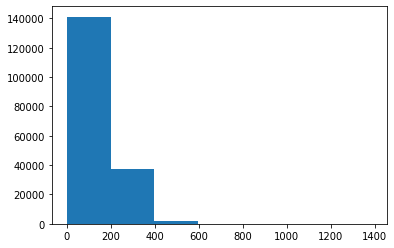

In [100]:
# check the distribution of our sequences at a character-level

import matplotlib.pyplot as plt

plt.hist(chars_lens, bins= 7);

In [101]:

# Find what character length covers 95% of sequences

output_seq_char_len = int(np.percentile(chars_lens, 95))
output_seq_char_len

290

In [102]:
# Get all keyboard characters 

random.choice(train_sentences)

# tenemos varios simbolos ademas del alfato

'strikingly , lttep had significantly less intravenous fluid than non-ltte patients ( @ l vs. @ l , p < @ ) , less time from tb to operating room ( @ minutes vs. @ min , p = @ ) , higher rate of intensive care unit admission ( @ % vs. @ % , p = @ ) , and a lower mortality rate ( @ % vs. @ % , p = @ ) .'

In [103]:
import string

alphabet = string.ascii_lowercase + string.digits + string.punctuation

alphabet


'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [104]:
# Create char-level token vectorizer instance


NUM_CHAR_TOKENS = len(alphabet) + 2 # add for space and 00V token (OOV=out of vocab, '[UNK]')

char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",# set standardization to "None" if you want to leave punctuation in
                                    name="char_vectorizer") # cantidad maxima de representacion por token

In [105]:
# Adapt character vectorizer to training character

char_vectorizer.adapt(train_chars)

In [106]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]} ")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i'] 
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [107]:
# Test out character vectorizer

random_train_chars = random.choice(train_chars)

print(f"Charified text:\n {random_train_chars}")


print(f"\nLength of random_train_chars:{len(random_train_chars.split())}")

# toma cualquier secuencia y retorna un vector de 290
vectorized_chars  = char_vectorizer([random_train_chars])

print(f"\Vectorized chars: \n {vectorized_chars}")

print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 t h r o u g h o u t   t h e   @ - y e a r   s p a n   u n d e r   r e v i e w   ,   t h e   n o n - s k i n   t h i n n i n g   t e s t   g r o u p   e x h i b i t e d   g o o d   p r e s e r v a t i o n   o f   t i s s u e   w i t h   d e c r e a s e d   s k i n   r e a c t i o n s   a n d   n o   a d v e r s e   e v e n t s   .

Length of random_train_chars:141
\Vectorized chars: 
 [[ 3 13  8  7 16 18 13  7 16  3  3 13  2 19  2  5  8  9 14  5  6 16  6 10
   2  8  8  2 21  4  2 20  3 13  2  6  7  6  9 23  4  6  3 13  4  6  6  4
   6 18  3  2  9  3 18  8  7 16 14  2 24 13  4 22  4  3  2 10 18  7  7 10
  14  8  2  9  2  8 21  5  3  4  7  6  7 17  3  4  9  9 16  2 20  4  3 13
  10  2 11  8  2  5  9  2 10  9 23  4  6  8  2  5 11  3  4  7  6  9  5  6
  10  6  7  5 10 21  2  8  9  2  2 21  2  6  3  9  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0

## Creating a character-level embedding

In [108]:
# Create char embedding layer

char_embed = layers.Embedding(input_dim=len(char_vocab),# numbe of different characters)
                              output_dim=25, # this is the size of the char embedding in the paper(figure 1)
                              mask_zero= True,
                              name="char_embed")
                              
                              





In [109]:
# Test our character embedding layer

print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))

print(f"Embedded chars. (after vectorization and embedding:\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

# En cada secuencia habra 290 char/token y seran representados cada uno por un vector de dimension 25

Charified text:
 t h r o u g h o u t   t h e   @ - y e a r   s p a n   u n d e r   r e v i e w   ,   t h e   n o n - s k i n   t h i n n i n g   t e s t   g r o u p   e x h i b i t e d   g o o d   p r e s e r v a t i o n   o f   t i s s u e   w i t h   d e c r e a s e d   s k i n   r e a c t i o n s   a n d   n o   a d v e r s e   e v e n t s   .

Embedded chars. (after vectorization and embedding:
[[[-0.03236883  0.00216844 -0.0192098  ...  0.0292382  -0.04570226
   -0.01412427]
  [-0.00526706 -0.0410773   0.03991809 ... -0.0005917   0.0127504
   -0.04921316]
  [-0.00024793  0.0192567   0.01884048 ... -0.04074172  0.00867199
    0.0305907 ]
  ...
  [ 0.01285866  0.03362694 -0.03267701 ... -0.03232787 -0.01927326
    0.00431943]
  [ 0.01285866  0.03362694 -0.03267701 ... -0.03232787 -0.01927326
    0.00431943]
  [ 0.01285866  0.03362694 -0.03267701 ... -0.03232787 -0.01927326
    0.00431943]]]

Character embedding shape: (1, 290, 25)


## Building  a Conv1D model to fit on character embeddings



In [110]:
# Make Conv1D on chars only

inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)

char_embeddings = char_embed(char_vectors)

x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)

x = layers.GlobalMaxPooling1D()(x)# si average no funciona, probar con max

outputs = layers.Dense(num_classes, activation="softmax")(x)

model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1d_char_embeddings")


# Compile

model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [111]:
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 290)               0         
_________________________________________________________________
char_embed (Embedding)       (None, 290, 25)           700       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 290, 64)           8064      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
__________________________________

In [112]:
# Create char level datasets

train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset
# tipo de data cadena, float

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [113]:
# Fit the model on chars only

model_3.history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1* len(train_char_dataset)),
                              epochs=5,
                              validation_data= val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/5
562/562 [==============================] - 4s 7ms/step - loss: 1.3871 - accuracy: 0.4328 - val_loss: 1.0548 - val_accuracy: 0.5642
Epoch 2/5
562/562 [==============================] - 4s 6ms/step - loss: 1.0403 - accuracy: 0.5817 - val_loss: 0.9481 - val_accuracy: 0.6167
Epoch 3/5
562/562 [==============================] - 4s 6ms/step - loss: 0.9449 - accuracy: 0.6285 - val_loss: 0.8754 - val_accuracy: 0.6539
Epoch 4/5
562/562 [==============================] - 4s 6ms/step - loss: 0.8923 - accuracy: 0.6523 - val_loss: 0.8479 - val_accuracy: 0.6712
Epoch 5/5
562/562 [==============================] - 3s 6ms/step - loss: 0.8595 - accuracy: 0.6599 - val_loss: 0.8300 - val_accuracy: 0.6759


In [114]:
# Make predictions with character model only

model_3_pred_probs = model_3.predict(val_char_dataset)

model_3_pred_probs

array([[0.29979032, 0.36964604, 0.10749754, 0.20424092, 0.01882518],
       [0.16794479, 0.73683155, 0.01535092, 0.05877538, 0.02109735],
       [0.18740079, 0.36427563, 0.08474822, 0.3025885 , 0.06098682],
       ...,
       [0.00495437, 0.01402002, 0.08634342, 0.00690864, 0.8877736 ],
       [0.02482192, 0.13711879, 0.28066665, 0.0336672 , 0.5237254 ],
       [0.30776617, 0.5072703 , 0.11603213, 0.05937487, 0.00955658]],
      dtype=float32)

In [115]:
# Convert prediction probabilities to classes



model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 1, ..., 4, 4, 1])>

In [116]:
# Calculate results for Conv1D model chars only

model_3_results = calculate_results(y_true= val_labels_encoded,
                                    y_pred = model_3_preds)

model_3_results

{'accuracy': 67.27128293393353,
 'f1': 0.6682475704089467,
 'precision': 0.6792700689659391,
 'recall': 0.6727128293393354}

In [117]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Model 4: Combining pretrained token embeddings + characters embeddings (hybrid embedding layer)

1. Create a token-level embedding model (similar `model_1`)
2. Create a character-level model(similar to `model_3`) with a slight modification

3. Combine 1 & 2  with a concatenate(`layers.Concatenate`)

4. Built a series of output layers on top of 3 similar to Figure 1 and section 4.2 of https://arxiv.org/pdf/1612.05252.pdf

5. Contruct a model wich takes token and character-level sequence as input and produces sequence label probabilities as outputs








In [119]:
# 1. Setup token inputs/model

token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")


token_embeddings = tf_hub_embedding_layer(token_inputs)

token_outputs = layers.Dense(128, activation="relu")(token_embeddings)

token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)




In [122]:
# 2. Setup char inputs/model

char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input" )

char_vectors = char_vectorizer(char_inputs)

char_embeddings = char_embed(char_vectors)
# recordar que para bidereccional el numero de unidades se multiplica por 2
char_bi_lstm= layers.Bidirectional(layers.LSTM(24))(char_embeddings)# bi-LSTM shown in figure 1 del paper

char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)


#3.concatenaremos matices
# Concatenate token and char inputs(create hybrid token embedding)

# le pasamos una lista de atributos de los modelos creados(output_atribuie)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

#. Create output layers - adding in Droput, discussed in section 4.2

# dropout coloca a 0  un ratio de los pesos aprendidos,  para evitar overfitting
combined_dropout=layers.Dropout(0.5)(token_char_concat)


combined_dense = layers.Dense(128,activation="relu")(combined_dropout)


final_dropout = layers.Dropout(0.5)(combined_dense)

output_layer = layers.Dense(num_classes,activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs

# podemos pasar una lista de atributos de entrada

model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")





In [123]:
# Get a summary of our model

model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_input[0][0]                 
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_input[0][0]                
__________________________________________________________________

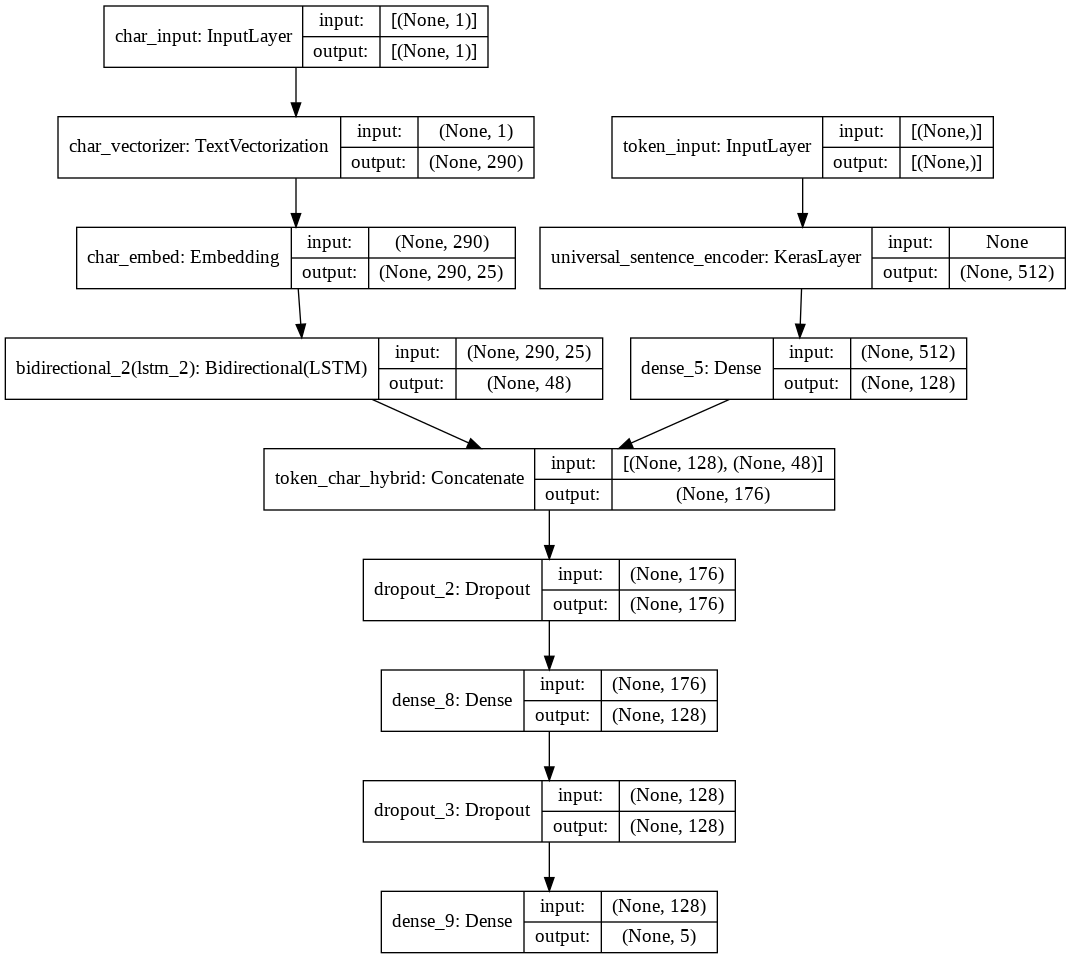

In [125]:
# Plot hybrid token and character model


from keras.utils import plot_model

plot_model(model_4, show_shapes=True)



In [126]:
# Compile token char model

model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),# section 4.2 of the paper says they use SGD
                metrics=["accuracy"])

###  Combining token and character data into a tf.data Dataset



In [ ]:
# hay que crearlos en el mismo orden que se creo el modelo 

# es decir primero abria que pasarle token y luego char!!

In [127]:
# combine chars and tokens into dataset

train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))# make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))# make labels
# unimos todo con el metodo zip que me permite unir 2 datset!!
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))# combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)









In [130]:
# Rpeat the above steps for our validation dataset
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))# make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))# make labels
# unimos todo con el metodo zip que me permite unir 2 datset!!
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))# combine data and labels

# Prefetch and batch train data

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [131]:
# check out our training char and token embedding dataser
train_char_token_dataset, val_char_token_dataset


(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

### fitting a model on token and character-level sequences



In [133]:
# Fit the model on tokens and chars

history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 35s 49ms/step - loss: 1.1558 - accuracy: 0.5269 - val_loss: 0.7791 - val_accuracy: 0.7011
Epoch 2/3
562/562 [==============================] - 25s 45ms/step - loss: 0.8092 - accuracy: 0.6838 - val_loss: 0.7225 - val_accuracy: 0.7264
Epoch 3/3
562/562 [==============================] - 23s 41ms/step - loss: 0.7800 - accuracy: 0.7014 - val_loss: 0.6904 - val_accuracy: 0.7387


In [134]:
model_2_results

{'accuracy': 71.29617370581227,
 'f1': 0.7099459627086563,
 'precision': 0.7128195024138995,
 'recall': 0.7129617370581226}

In [135]:
# Evaluate one the whole validation dataset

model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 20s 21ms/step - loss: 0.6949 - accuracy: 0.7328


[0.6949127316474915, 0.7328214049339294]

In [136]:
# Make predictions using the token-character model hybrids

model_4_pred_probs = model_4.predict(val_char_token_dataset)

model_4_pred_probs


array([[5.2035350e-01, 2.9553923e-01, 3.8069980e-03, 1.7340781e-01,
        6.8924986e-03],
       [3.8849294e-01, 4.0611097e-01, 4.7459533e-03, 1.9725563e-01,
        3.3945304e-03],
       [3.0297646e-01, 1.5301557e-01, 3.6206968e-02, 4.7902828e-01,
        2.8772714e-02],
       ...,
       [1.8687223e-04, 6.3037900e-03, 3.7107512e-02, 5.1131599e-05,
        9.5635068e-01],
       [6.7619844e-03, 7.0697486e-02, 1.9725938e-01, 2.8796499e-03,
        7.2240150e-01],
       [2.4074841e-01, 3.7542099e-01, 2.7907205e-01, 2.9866759e-02,
        7.4891768e-02]], dtype=float32)

In [138]:
# Format pred probs into pred labels

model_4_preds = tf.argmax(model_4_pred_probs, axis=1)


model_4_preds


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [139]:
# Get results or token-char-hybrid model

model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)


In [140]:
model_4_results

{'accuracy': 73.28213954719979,
 'f1': 0.7297067488786805,
 'precision': 0.7350393887147801,
 'recall': 0.7328213954719979}

In [144]:
model_1_results

{'accuracy': 78.49860982391102,
 'f1': 0.7821969091795758,
 'precision': 0.7814319919446246,
 'recall': 0.7849860982391103}

## Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embedding

In [146]:

train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> **Note:** Any engineered features used to train a model need to be availabel at test time. In out case, line numers and total lines are available

### Create postional embeddings(espacio de caracteristicas)

In [148]:
# How many different line numbers are there?

train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

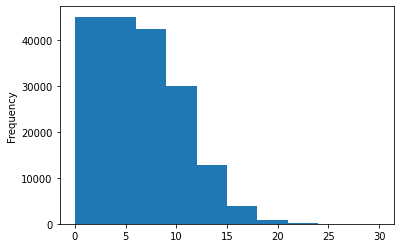

In [149]:
# Check the distribution of "line_number" column

train_df["line_number"].plot.hist()

In [155]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
# limitamos la cantidad de numeros o clases para evitar problemas de dimension excesiva
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

train_line_numbers_one_hot[:14], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(14, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

Now we've encoded our line numbers feature, let's do the same for our total lines feature...

In [156]:
# How many different numbers of lines are there"?
train_df.total_lines.value_counts()


11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

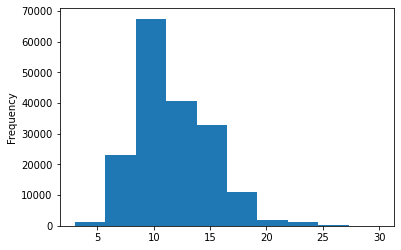

In [157]:
# Check the distributuions of total_lines
train_df.total_lines.plot.hist();

In [158]:
# Check the coverage of a "total_lines" value of 20
# con 20 clases ya habremos cubierto la mayoria de las clases
np.percentile(train_df.total_lines, 95)

18.0

In [160]:
# Use TensorFlow to create one-hot-enconded tensor of our "total_lines" feature
train_total_lines_one_hot =tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot =tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot =tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)



train_total_lines_one_hot, train_total_lines_one_hot[:10]

(<tf.Tensor: shape=(180040, 20), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.

### Building a tribrid embedding model
1. Create a token-level model

2. Create a charater-level model

3. create a model for the "the line_number" feature

4. create a model for the "total_lines" feature

5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate


6. combine the outputs of 3, 4, 5 using tf.keras.layers.Concatenate

7. Create an output layer to accept the tribried embedding and output label probabilities

8. Combine the inputs of 1,2 3, 4  and outputs of into a tf.keras.Model



In [162]:
train_line_numbers_one_hot[0].shape

TensorShape([15])

In [163]:
train_total_lines_one_hot[0].shape, train_total_lines_one_hot[0].dtype

(TensorShape([20]), tf.float32)

In [168]:
# 1. Token inputs

token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")

token_embeddings = tf_hub_embedding_layer(token_inputs)

token_outputs = layers.Dense(128, activation="relu")(token_embeddings)

token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)


# 2. chaer inputs

char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")

char_vectors = char_vectorizer(char_inputs)

char_embeddings = char_embed(char_vectors)

char_bi_lstm =layers.Bidirectional(layers.LSTM(24))(char_embeddings)

char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)


# 3. line numbers model

line_number_inputs= layers.Input(shape=(15,), dtype=tf.float32, name = "line_number_inputs")
# Dense layer with 32 units & relu activation
x = layers.Dense(32, activation="relu")(line_number_inputs)

# combine inputs & dense layer into model


line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)


# 4. Total lines model

total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_inputs")

y = layers.Dense(32, activation="relu")(total_lines_inputs)

total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)


# 5. Comine token and char embeddings into a hybrid embeddings

combined_embeddings = layers.Concatenate(name="char_token_hybrid_embeddings")([token_model.output,
                                                                               char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)

z = layers.Dropout(0.5)(z)

#  6. Combine positional embedding with combined token and char embeddings

tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                 total_line_model.output,
                                                                                 z])

# 7. Create output layer

output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(tribrid_embeddings)

#  8. Put together model with all kinds of inputs

# el orden es importante recordar
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name="tribid_embeddings_model")






In [169]:
# Get a summary of our tribrid model

model_5.summary()

Model: "tribid_embeddings_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_inputs[0][0]               
____________________________________________________________________________

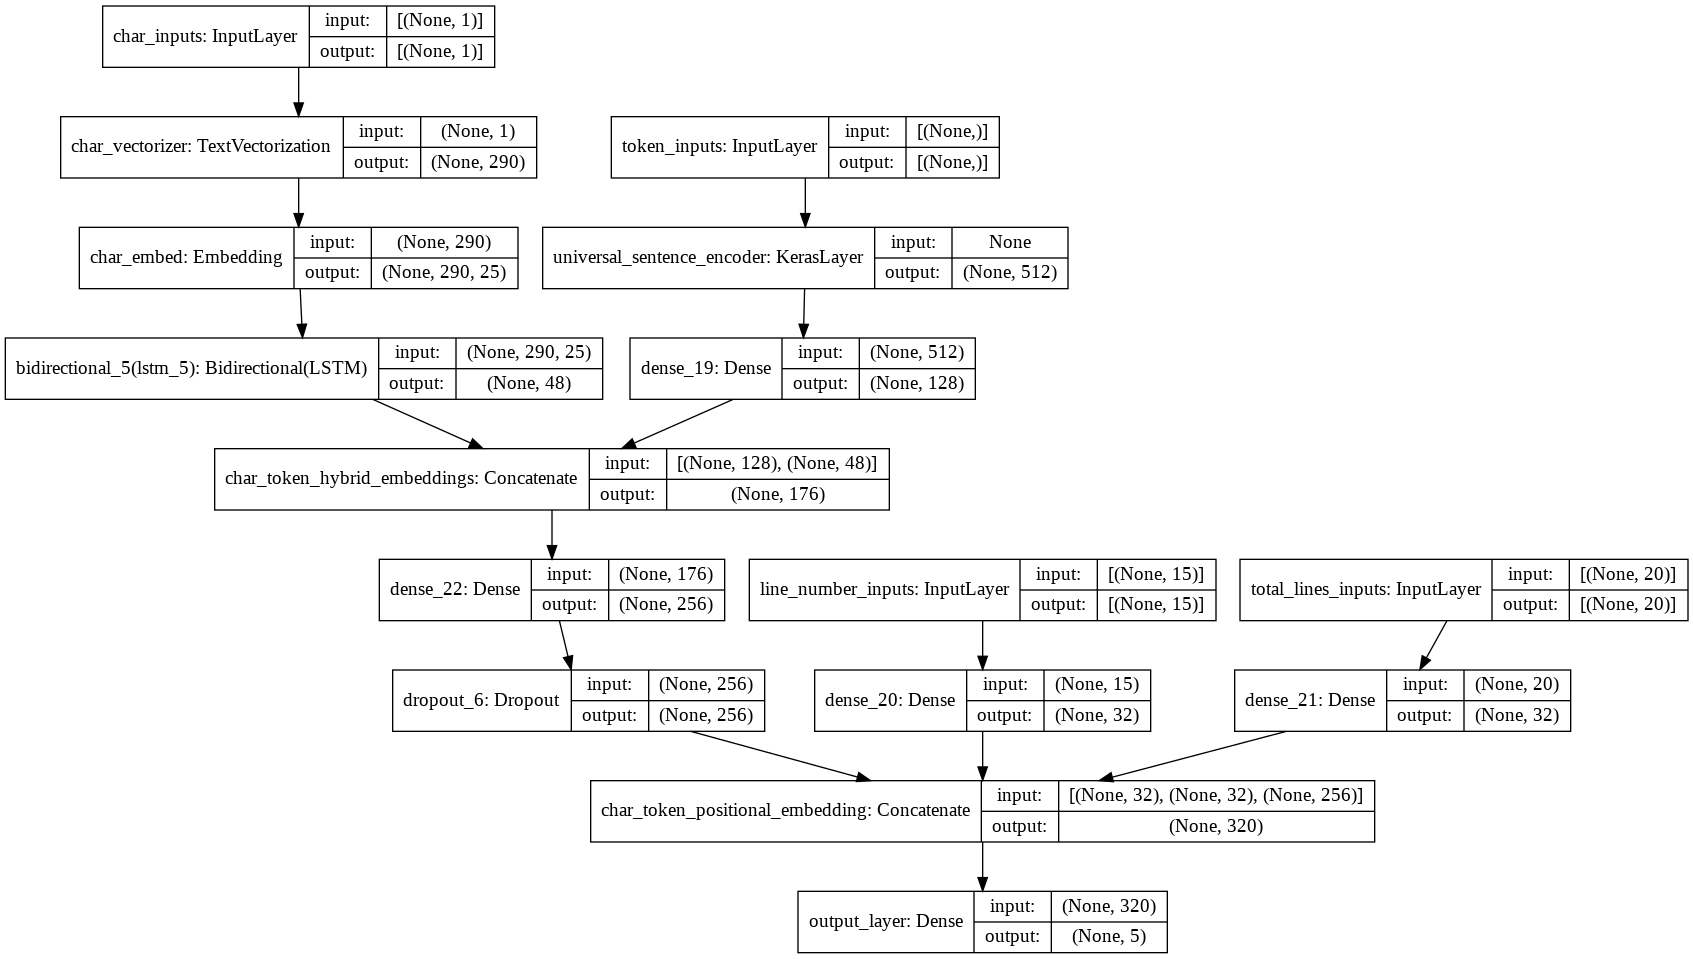

In [173]:
# Plot model_5 to explore it visually
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)


What is label smoothing?

for example,if our model gets too confident on a single class (e.g its prediction probability is really high), it may get stuck on that class and not considet other classes

really confident `[0.0, 0.0, 1, 0.0, 0,0]`

what label smoothing does is it assigns some of the values from the highest pred prob to other classes, in turn, hopefully improving genrelization

`[0.01, 0.01, 0.96, 0.01` es decir hace una reparticion

"model considera las otras probabilidades"


> for more on label smoothing, see this blog post from PyImageSearch:

https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/






In [174]:
#Compile token, char, and positional embedding model

model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),# helps tu prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Create tribrid embedding datasets using tf.data




In [190]:
# Create training and validation datasets( with all four kinds of inputs daa)

# usar el orden adecuado

train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))

train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))

train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above but for the validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))

val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))

val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [191]:
# Check input shapes

train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

### Fitting, evaluating and making predictions with our tribid model



In [193]:
# Fit our tribrid embedding model

history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 37s 53ms/step - loss: 1.2273 - accuracy: 0.6220 - val_loss: 0.9864 - val_accuracy: 0.8029
Epoch 2/3
562/562 [==============================] - 27s 49ms/step - loss: 0.9736 - accuracy: 0.8102 - val_loss: 0.9507 - val_accuracy: 0.8251
Epoch 3/3
562/562 [==============================] - 25s 45ms/step - loss: 0.9577 - accuracy: 0.8157 - val_loss: 0.9408 - val_accuracy: 0.8328


In [194]:
# Make predictions with the char token pos model

model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)

model_5_pred_probs

945/945 [==============================] - 24s 22ms/step


array([[0.50097084, 0.10666462, 0.00928902, 0.3670477 , 0.01602784],
       [0.5417041 , 0.12240355, 0.04760695, 0.27819625, 0.01008916],
       [0.24702562, 0.12474651, 0.09023408, 0.47792765, 0.06006616],
       ...,
       [0.03433565, 0.12466201, 0.04300471, 0.0316653 , 0.7663323 ],
       [0.0308525 , 0.3332819 , 0.07689493, 0.02618459, 0.532786  ],
       [0.22343889, 0.5892861 , 0.09517457, 0.03817714, 0.05392332]],
      dtype=float32)

In [195]:
# Convert pred probs to pred labels

model_5_preds = tf.argmax(model_5_pred_probs, axis=1)

model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [196]:
# Calculate results of char token pos model
model_5_results = calculate_results(y_true =val_labels_encoded,
                                    y_pred=model_5_preds)

model_5_results
# a;adiendo las engineered features obtuvimos un 10 % adicional en la accuracy

{'accuracy': 83.32450681848272,
 'f1': 0.8326348869847351,
 'precision': 0.8325921942876616,
 'recall': 0.8332450681848272}

In [197]:
model_4_results

{'accuracy': 73.28213954719979,
 'f1': 0.7297067488786805,
 'precision': 0.7350393887147801,
 'recall': 0.7328213954719979}

## Compare model results



In [199]:
# Combine model results into a dataframe

all_model_results = pd.DataFrame({
    "model_0_baseline":baseline_results,
    "model_1_custom_token_embedding":model_1_results,
    "model_2_pretrained_token_embedding":model_2_results,
    "model_3_custom_char_embedding": model_3_results,
    "model_4_hybrid_char_token_embedding":model_4_results,
    "model_5_pos_char_token_embedding":model_5_results


})

all_model_results = all_model_results.transpose()

all_model_results.head()

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.498610,0.781432,0.784986,0.782197
model_2_pretrained_token_embedding,71.296174,0.712820,0.712962,0.709946
model_3_custom_char_embedding,67.271283,0.679270,0.672713,0.668248
model_4_hybrid_char_token_embedding,73.282140,0.735039,0.732821,0.729707


In [200]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100





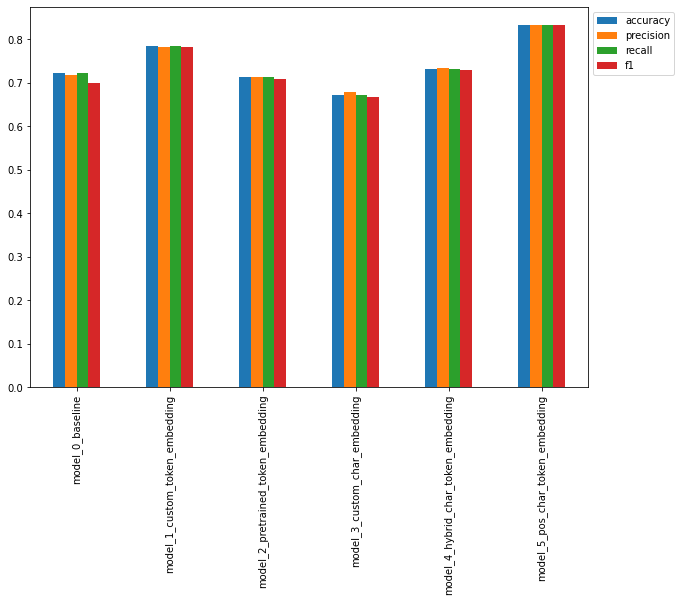

In [201]:
# PLot and compare all model results

all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

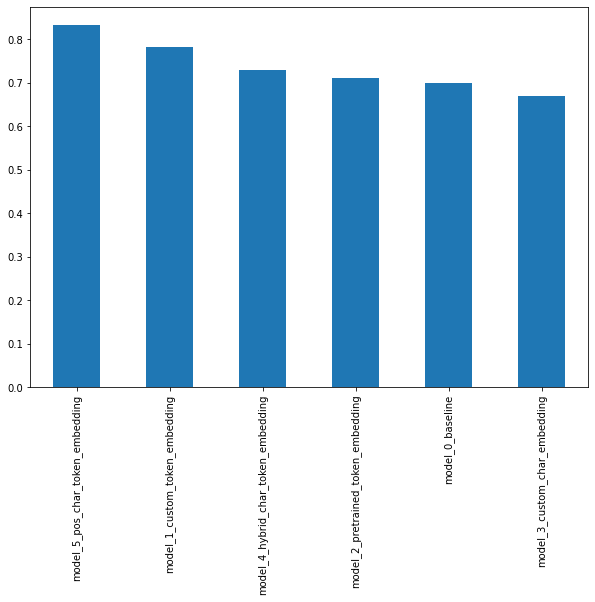

In [202]:
# sort models results by f1-score

all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar",figsize=(10, 7))

## Save and load model

In [203]:

# Save the best perfoming model to SaveModel format (Default)

model_5.save("skimlit_tribrid_model")

INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


In [204]:
# Load in best perfoming model

loaded_model = tf.keras.models.load_model("skimlit_tribrid_model")

In [205]:
model_5_results

{'accuracy': 83.32450681848272,
 'f1': 0.8326348869847351,
 'precision': 0.8325921942876616,
 'recall': 0.8332450681848272}

In [206]:
# Make prediction with the loaded model on the validation set
loaded_pred_probs = loaded_model.predict(val_char_token_pos_dataset)

loaded_preds = tf.argmax(loaded_pred_probs, axis=1)

loaded_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [208]:
# Calcualte the results of our loaded model

loaded_model_results = calculate_results(y_true=val_labels_encoded,
                                         y_pred=loaded_preds)

loaded_model_results

{'accuracy': 83.32450681848272,
 'f1': 0.8326348869847351,
 'precision': 0.8325921942876616,
 'recall': 0.8332450681848272}

In [209]:
model_5_results

{'accuracy': 83.32450681848272,
 'f1': 0.8326348869847351,
 'precision': 0.8325921942876616,
 'recall': 0.8332450681848272}

In [210]:
assert model_5_results == loaded_model_results

In [211]:
# Check the loaded model summary

loaded_model.summary()

Model: "tribid_embeddings_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_inputs[0][0]               
____________________________________________________________________________

## Download and load in a pretained model from google Storage



In [212]:
import tensorflow as tf

import tensorflow_hub as hub

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization






In [213]:
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip

--2021-05-21 01:39:10--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.128, 142.250.141.128, 2607:f8b0:4023:c06::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962957902 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 918.35M   106MB/s    in 9.8s    

2021-05-21 01:39:20 (93.3 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962957902/962957902]



In [214]:
!mkdir skimlit_gs_model

#descomprimer en la la carpeta creada arriba
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
   creating: skimlit_gs_model/skimlit_tribrid_model/assets/
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.index  
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.data-00000-of-00001  
  inflating: skimlit_gs_model/skimlit_tribrid_model/saved_model.pb  


In [215]:
# Load in downloaded Google storage model

loaded_gs_model = tf.keras.models.load_model("skimlit_gs_model/skimlit_tribrid_model/")




In [218]:
# Evaluate the loaded Google Storage model

loaded_gs_model.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 23s 22ms/step - loss: 0.9459 - accuracy: 0.8283


[0.9459028244018555, 0.8283132314682007]

## Your challengess

1. Turn the test data samples into a tf.data Dataset(fast loading) and then
evaluate (make predictions) the best perfoming model on the test samples.

2. Find the most wrong prediction from 1 ( these are the samples where the model has predicted the wrong label with the hieghest prediction probability).


3. Make example predictios (on RCT abstractrs from the wild), you can go to PubMed to find these




